In [3]:
# Load dataset and gpt2

In [1]:
import sys
sys.path.append("../src/")
%load_ext autoreload
%autoreload 2

import data_utils as du

In [2]:
data = du.get_wiki_data(0, 10)

INFO:absl:No config specified, defaulting to first: wiki40b/en
INFO:absl:Load dataset info from gs://tfds-data/datasets/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (gs://tfds-data/datasets/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split train[0:10], from gs://tfds-data/datasets/wiki40b/en/1.3.0


In [4]:
data = du.get_wiki_data(0, 100)
paragraphs = []
for d in data:
    paragraphs.extend(du.get_paragraphs(d))

INFO:absl:No config specified, defaulting to first: wiki40b/en
INFO:absl:Load dataset info from gs://tfds-data/datasets/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (gs://tfds-data/datasets/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split train[0:100], from gs://tfds-data/datasets/wiki40b/en/1.3.0


In [5]:
import msgpack


In [6]:
with open("/tmp/msgpacktest.msgpack", "wb") as buf:
    for para in paragraphs:
        buf.write(msgpack.packb(para, use_bin_type=True))

In [8]:
back = []
with open("/tmp/msgpacktest.msgpack", "rb") as buf:
    unpacker = msgpack.Unpacker(buf, raw=False)
    for unpacked in unpacker:
        back.append(unpacked)

In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [4]:
paragraphs = [p.replace("\n", " ") for p in paragraphs]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
pass

In [36]:
tokenized_paras = []
for para in paragraphs:
    toked = tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])

In [37]:
len(tokenized_paras)

1246

In [38]:
x = model(tokenized_paras[0], labels=tokenized_paras[0], return_dict=True)

In [39]:
x.logits.shape

torch.Size([1, 512, 50257])

In [42]:
import torch

In [50]:
with torch.no_grad():
    shift_logits = x.logits[..., :-1, :].contiguous()
    shift_labels = tokenized_paras[0][..., 1:].contiguous()
    # Flatten the tokens
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

In [52]:
loss.shape

torch.Size([511])

In [38]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

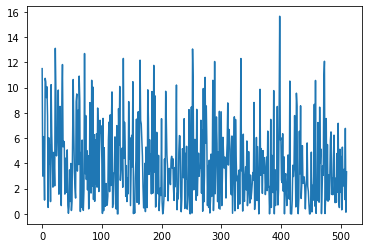

In [51]:
plt.plot(loss)

In [62]:
%%time 
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    with torch.no_grad():
        out = model(para, labels=para, return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para[..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 100:
        break

CPU times: user 3min 12s, sys: 18.2 s, total: 3min 30s
Wall time: 2min 51s


In [63]:
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)
mean_losses.shape

(511,)

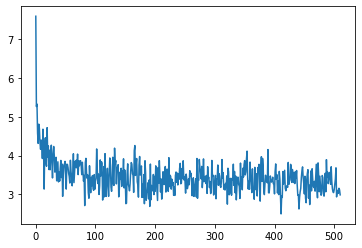

In [64]:
plt.plot(mean_losses)

In [41]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

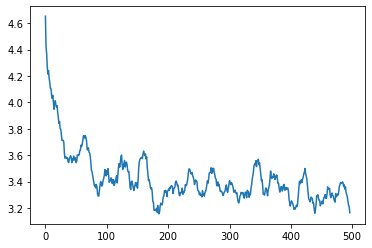

In [68]:
plt.plot(moving_average(mean_losses, 15))

In [69]:
smoothed = []
for i in range(len(mean_losses) - 10):
    smoothed.append(np.mean(mean_losses[i:i+10]))

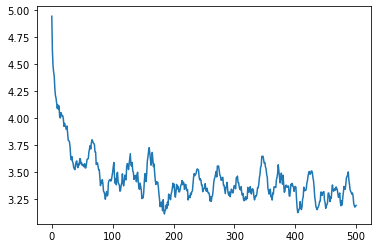

In [70]:
plt.plot(smoothed)

In [76]:
from transformers import ReformerTokenizer, ReformerModel

reformer_tokenizer = ReformerTokenizer.from_pretrained('google/reformer-crime-and-punishment')
reformer_model = ReformerModel.from_pretrained('google/reformer-crime-and-punishment')

Some weights of ReformerModel were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.0.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.3.atten

/Users/daniter/anaconda3/envs/iterdiscoher/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [31]:
from transformers import XLNetTokenizer, XLNetLMHeadModel

In [33]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetLMHeadModel.from_pretrained('xlnet-base-cased')

In [36]:
import torch
import numpy as  np

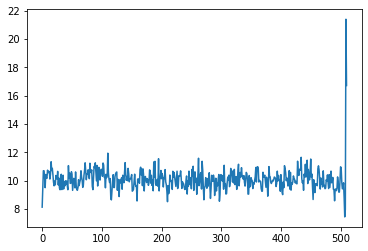

In [39]:
xlnet_tokenized_paras = []
for para in paragraphs:
    toked = xlnet_tokenizer(para, return_tensors="pt", truncation=True, max_length=512)
    if toked['input_ids'].shape[1] >= 512:
        xlnet_tokenized_paras.append(toked)
        if len(xlnet_tokenized_paras) > 100:
            break

losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(xlnet_tokenized_paras):
    with torch.no_grad():
        out = xlnet_model(**para, labels=para['input_ids'], return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para['input_ids'][..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 50:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)
plt.plot(mean_losses)

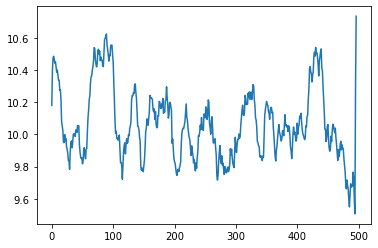

In [42]:
plt.plot(moving_average(mean_losses, 15))

In [56]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel

gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
gpt_model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
gpt_model.eval()
pass

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
tokenized_paras = []
for para in paragraphs:
    toked = gpt_tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])
    if len(tokenized_paras) > 100:
        break
        
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    with torch.no_grad():
        out = gpt_model(para, labels=para, return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para[..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 50:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)


Token indices sequence length is longer than the specified maximum sequence length for this model (830 > 512). Running this sequence through the model will result in indexing errors


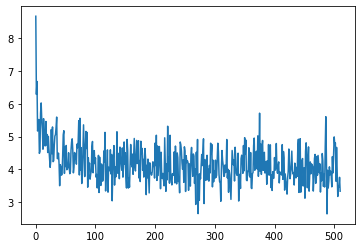

In [58]:
plt.plot(mean_losses)

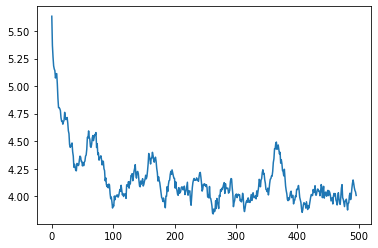

In [59]:
plt.plot(moving_average(mean_losses, 15))

In [71]:
from transformers import TransfoXLTokenizer, TransfoXLLMHeadModel

txl_tokenizer = TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')
txl_model = TransfoXLLMHeadModel.from_pretrained('transfo-xl-wt103')
txl_model.eval()

tokenized_paras = []
for para in paragraphs:
    toked = txl_tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])
    if len(tokenized_paras) > 100:
        break
        
print("Done tokenizing")
        
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    print(i)
    with torch.no_grad():
        out = txl_model(para, labels=para, return_dict=True)
        losses.append(out.losses)
    if i > 25:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)


Done tokenizing
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


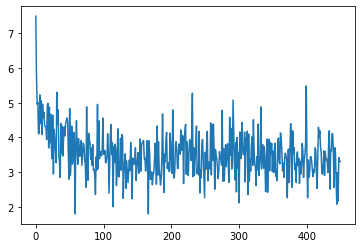

In [80]:
plt.plot(mean_losses.ravel()[:450])

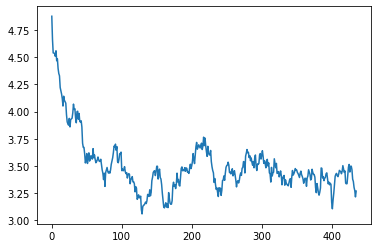

In [79]:
plt.plot(moving_average(mean_losses.ravel()[:450], 15))

In [47]:
from transformers import ReformerTokenizer, ReformerModel

reformer_tokenizer = ReformerTokenizer.from_pretrained('google/reformer-enwik8')
reformer_model = ReformerModel.from_pretrained('google/reformer-enwik8')

OSError: Can't load tokenizer for 'google/reformer-enwik8'. Make sure that:

- 'google/reformer-enwik8' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'google/reformer-enwik8' is the correct path to a directory containing relevant tokenizer files



In [25]:
out = xlnet_model(**para, labels=para['input_ids'], return_dict=True)

In [26]:
out.keys()

odict_keys(['last_hidden_state', 'mems'])

In [29]:
out = xlnet_model(input_ids=para['input_ids'], token_type_ids=para['token_type_ids'],
                  attention_mask=para['attention_mask'], labels=para['input_ids'], return_dict=True)

In [28]:
para.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [30]:
out.keys()

odict_keys(['last_hidden_state', 'mems'])